## Dataset and assignment information

The purpose of this project is to apply Generative Adversarial Networks (GAN) to the machine model. The model is to implement recognition of  digit 1 and digit 5 from Digits MNIST handwriting dataset. Data is imported from Tensorflow Keras consisting of digits from zero (0) to nine (9). 

In this model, Deep Convolutional Generative Adversarial Networks (DCGANs) is applied to enhances their ability to capture and generate complex patterns in images.

## Import functions and packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from matplotlib import pyplot

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load and explore dataset

In [2]:
# Load Digits MNIST dataset 
datasets_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = datasets_mnist

Saving figure X_train_full_mnist


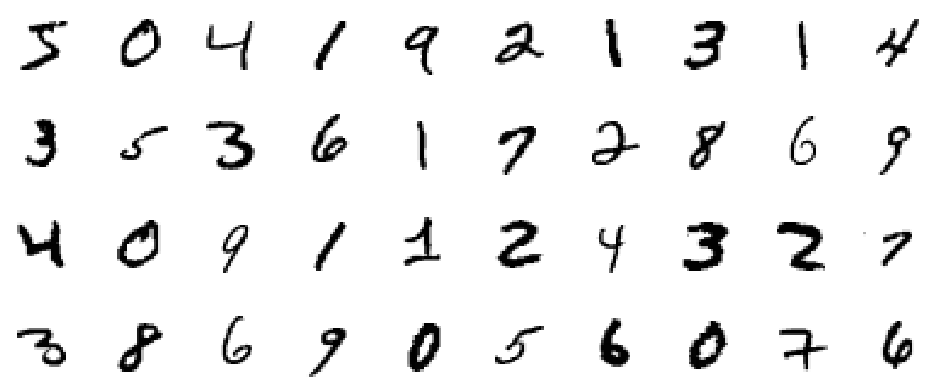

In [3]:
# Display example of the images from the X_train_full (original) dataset
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_full[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('X_train_full_mnist', tight_layout=False)
plt.show()

In [4]:
X_train_full.shape

(60000, 28, 28)

In [5]:
# Split data into Training set, Test set and Validation set and normalize them by deviding by 255 with decimal
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

# Print number of examples for each dataset
print("Number of original training examples:", len(X_train))
print("Number of original validation examples:", len(X_valid))
print("Number of original test examples:", len(X_test))

Number of original training examples: 55000
Number of original validation examples: 5000
Number of original test examples: 10000


In [6]:
X_train_full.dtype # Display data typse

dtype('uint8')

In [7]:
# Filter data to keep only 1 and 5 , and convert the label y to boolean; True for 1 and False for 5
def filter_15(X, y):
    keep = (y == 1) | (y ==5)
    X, y = X[keep], y[keep]
    y = y == 1
    return X,y

In [8]:
# Split data into Training set, Test set and Validation set after getting the result from filter_15 function to only gather images with digit 1 and 5
X_train, y_train = filter_15(X_train, y_train)
X_test, y_test = filter_15(X_test, y_test)
X_test = X_test / 255.

# Print number of examples for each dataset
print("Number of original training examples:", len(X_train))
print("Number of original validation examples:", len(X_valid))
print("Number of original test examples:", len(X_test))

Number of original training examples: 11166
Number of original validation examples: 5000
Number of original test examples: 2027


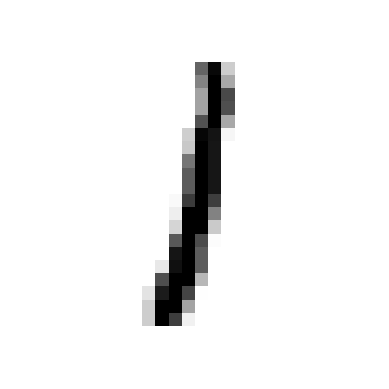

In [9]:
# Display the first element from the training set
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [10]:
X_train.shape # Get the dimensions of the training set

(11166, 28, 28)

In [11]:
y_train # show the result of the training set

array([ True,  True,  True, ..., False,  True, False])

Saving figure X_train_mnist


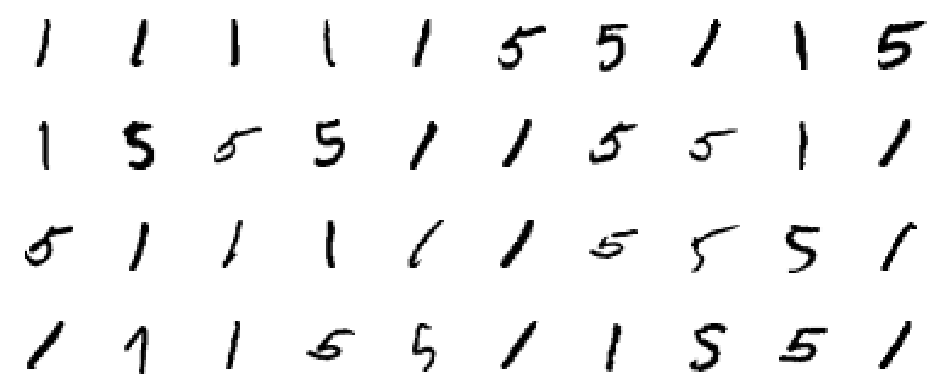

In [12]:
# Display images of the results from training dataset in 4 rows and 10 columns
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('X_train_mnist', tight_layout=False)
plt.show()

## Deep Convolutional GAN


In [13]:
tf.random.set_seed(42)  # generate random seed

# Set the size of the latent space (input noise vector) for the generator.
codings_size = 100

# Generator with added layers
generator = tf.keras.Sequential([
    # First, a Dense layer is used to create a large number of features from the input noise vector.
    tf.keras.layers.Dense(7 * 7 * 256),

    # These features are then reshaped into a 3D format to be processed by convolutional layers.
    tf.keras.layers.Reshape([7, 7, 256]),

    # Batch normalization is used to stabilize training by normalizing the input to each activation layer.
    tf.keras.layers.BatchNormalization(),

    # Conv2DTranspose (deconvolution) layers upsample the input and increase the spatial dimensions (height and width).
    tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),

    # Dropout is added for regularization to prevent overfitting.
    tf.keras.layers.Dropout(0.3),

    # Further upsampling to reach the desired image size.
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),

    # Final Conv2DTranspose layer outputs the image with the desired number of channels (e.g., 1 for grayscale).
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh"),
])


# Discriminator with added layers
discriminator = tf.keras.Sequential([
    # Conv2D layer for feature extraction. The use of strided convolutions reduces the spatial dimensions.
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),

    # Dropout to prevent overfitting.
    tf.keras.layers.Dropout(0.4),

    # Additional Conv2D layers increase the network's capacity to differentiate between real and fake images.
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),

    # Further increase in depth to enhance feature extraction.
    tf.keras.layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),

    # Flatten the output in preparation for the final classification layer.
    tf.keras.layers.Flatten(),

    # Dense layer for binary classification (real or fake).
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# Combining the Generator and Discriminator to form the GAN.
# The Generator tries to generate realistic images and 
# the Discriminator tries to differentiate between real and generated images.
gan = tf.keras.Sequential([generator, discriminator])


In [14]:
# Compile the discrimator and the gan, as earlier
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Set discriminator's weight to false so thw model only train generator's weight
# for better images
discriminator.trainable = False 

gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [15]:
# Reshape and rescale
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 0.5 - 1. 

In [16]:
# Generate the dataset and trains the GAN, just like earlier
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [17]:
# A function to plot a grid of images
def plot_multiple_images(images, n_cols=None):
    # Set the number of columns for the plot. If not provided, use the number of images.
    n_cols = n_cols or len(images)

    # Calculate the number of rows needed to display all images.
    n_rows = (len(images) - 1) // n_cols + 1

    # If the images have a single channel (grayscale), remove the channel dimension for plotting.
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)  # Squeeze the channel dimension

    # Create a figure with the calculated number of rows and columns.
    plt.figure(figsize=(n_cols, n_rows))

    # Loop through each image and plot it.
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)  # Create a subplot for each image
        plt.imshow(image, cmap="binary")  # Display the image in grayscale
        plt.axis("off")  # Turn off the axis to make the plot cleaner


Epoch 1/30


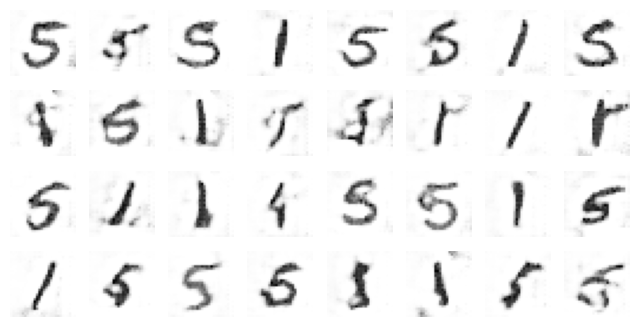

Epoch 2/30


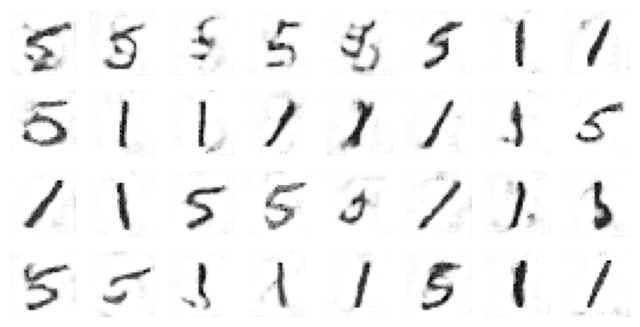

Epoch 3/30


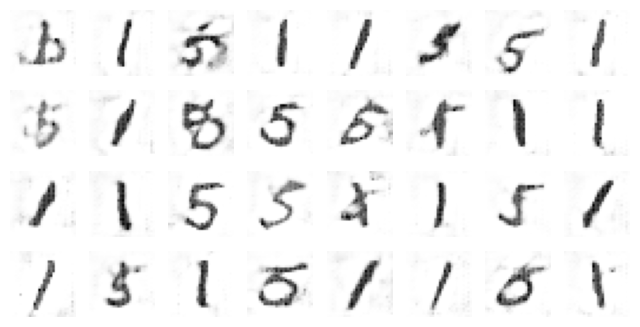

Epoch 4/30


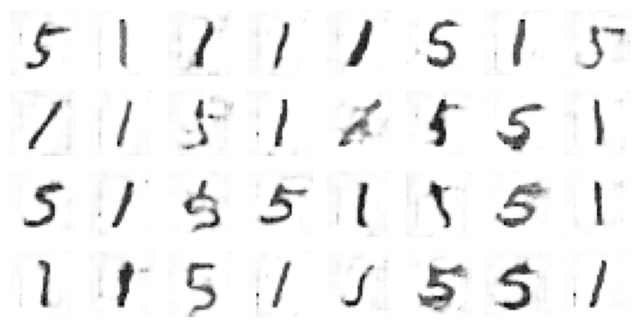

Epoch 5/30


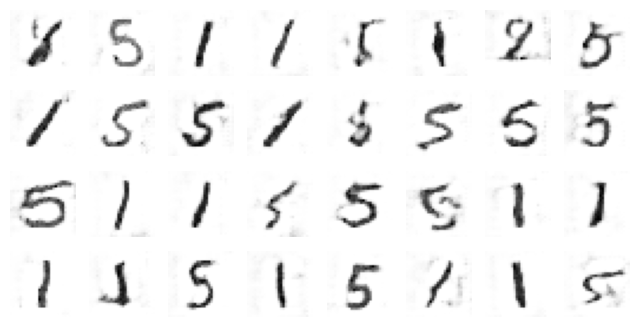

Epoch 6/30


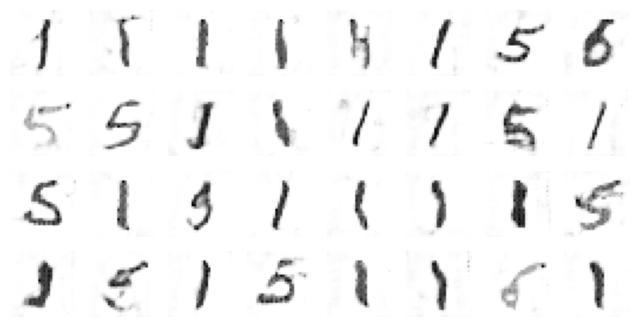

Epoch 7/30


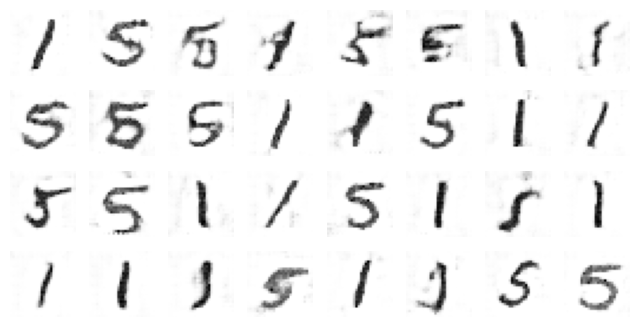

Epoch 8/30


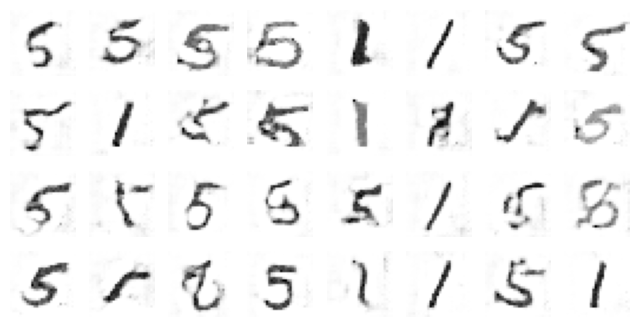

Epoch 9/30


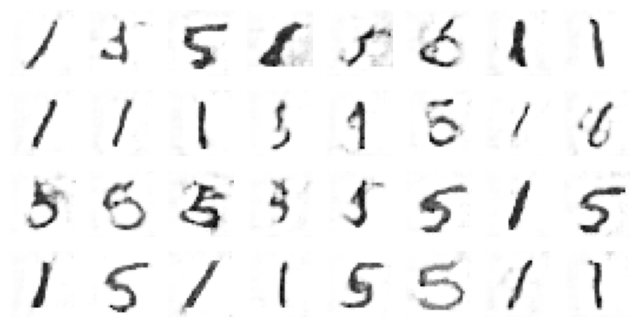

Epoch 10/30


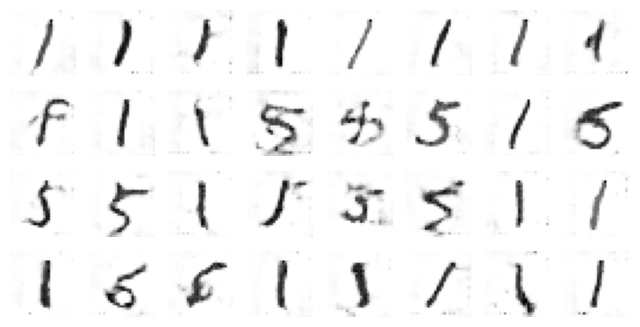

Epoch 11/30


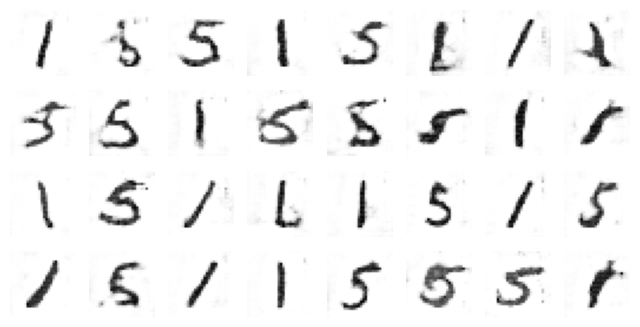

Epoch 12/30


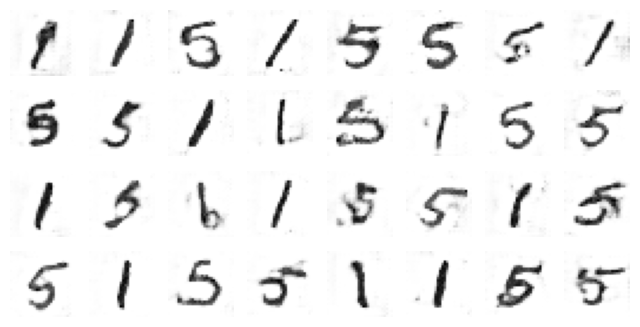

Epoch 13/30


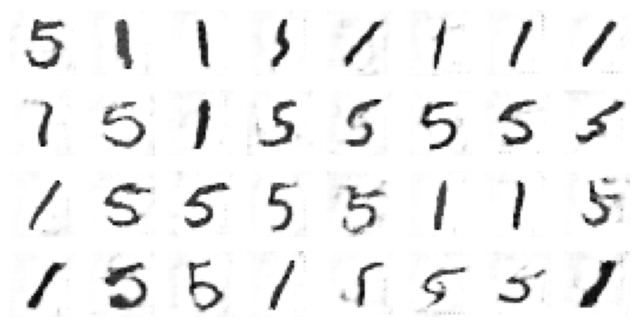

Epoch 14/30


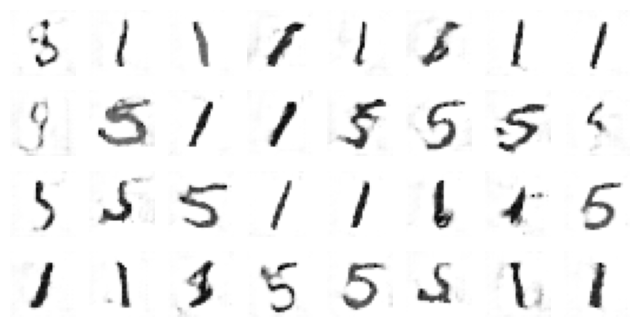

Epoch 15/30


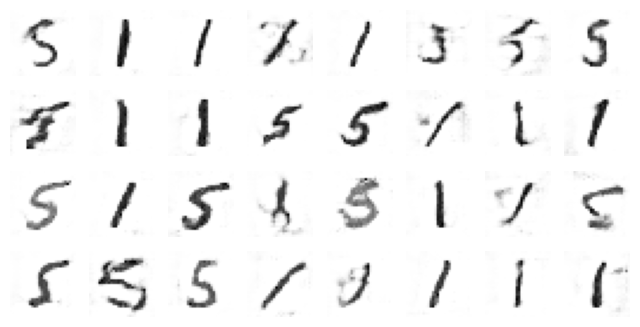

Epoch 16/30


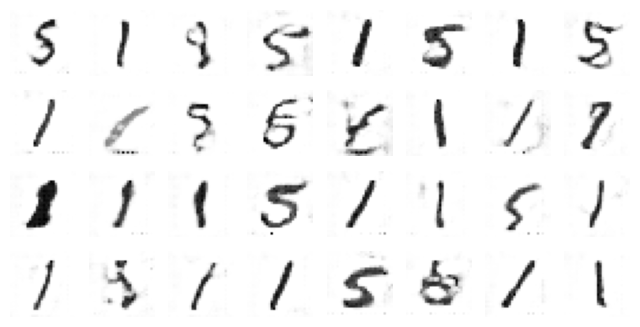

Epoch 17/30


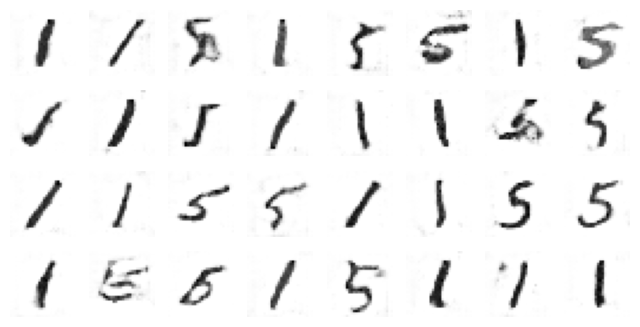

Epoch 18/30


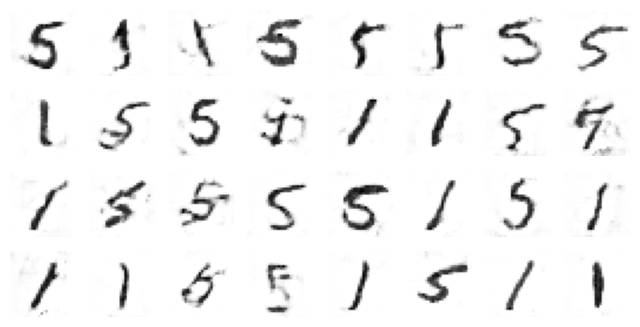

Epoch 19/30


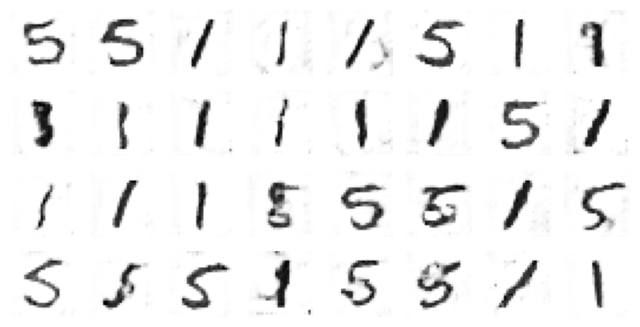

Epoch 20/30


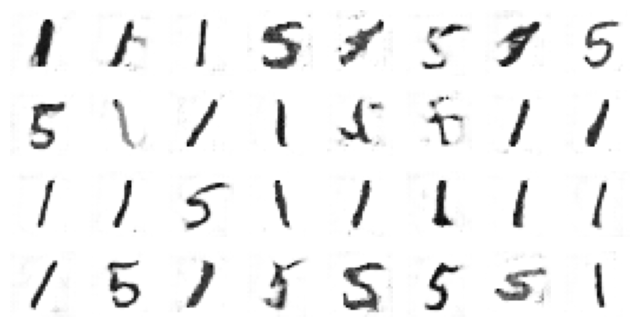

Epoch 21/30


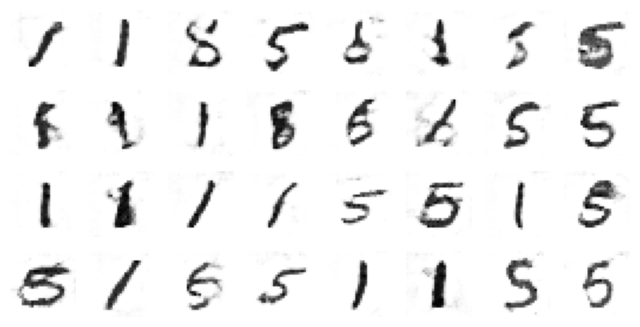

Epoch 22/30


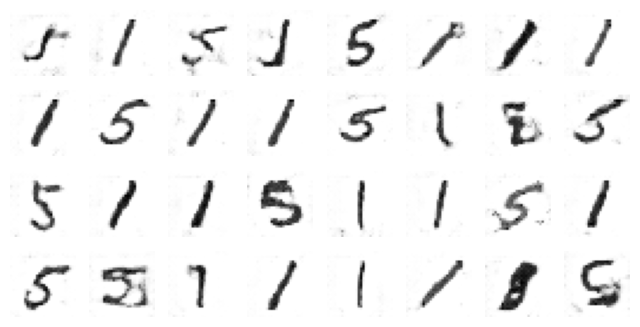

Epoch 23/30


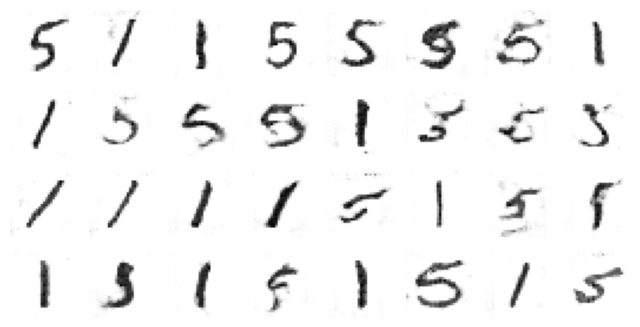

Epoch 24/30


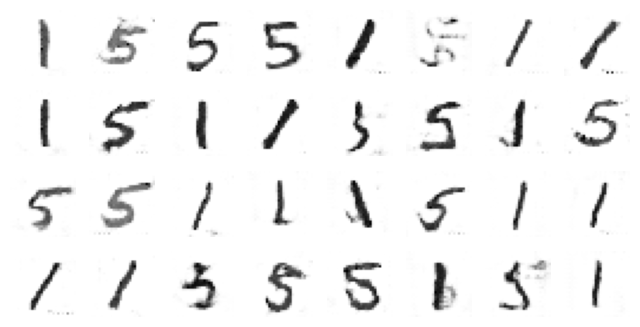

Epoch 25/30


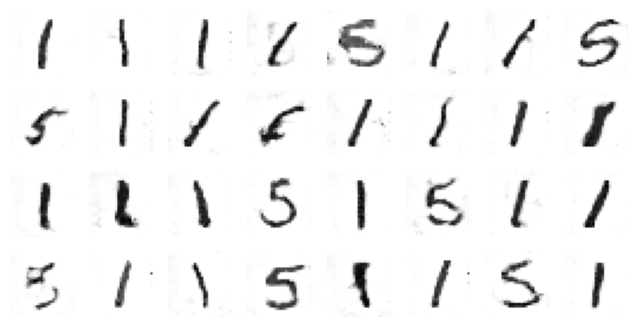

Epoch 26/30


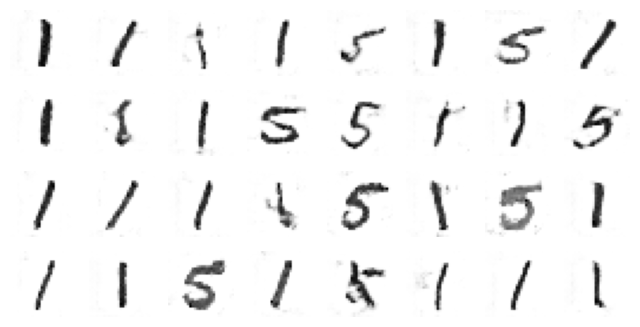

Epoch 27/30


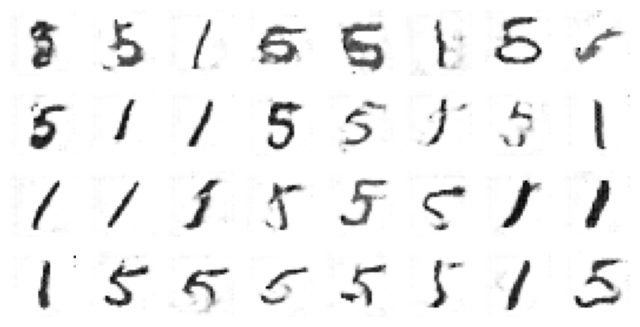

Epoch 28/30


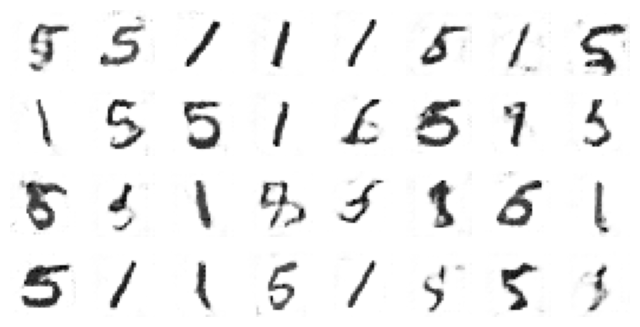

Epoch 29/30


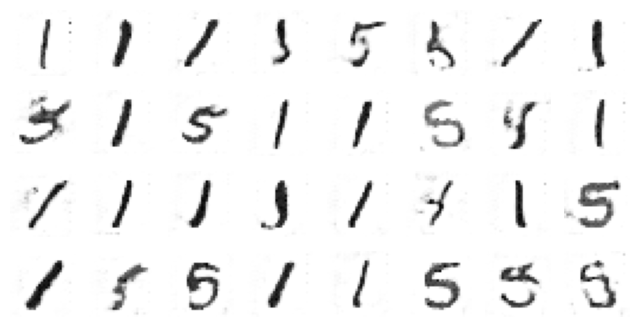

Epoch 30/30


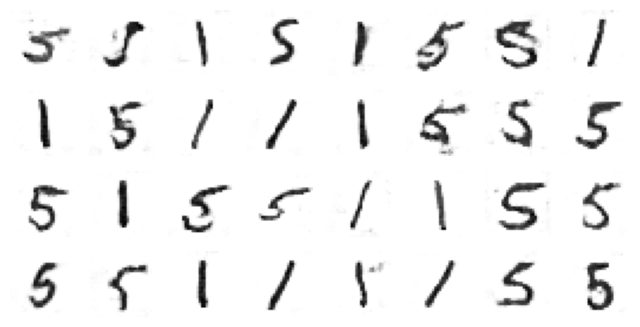

In [22]:
# A function to train Generative Adversarial Network (GAN)
# which includes both the generator and discriminator.
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # Ensure the data type is consistent (float32)
            X_batch = tf.cast(X_batch, tf.float32)

            # Phase 1 - Training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            # Ensure generated images have the same data type as the real images
            generated_images = tf.cast(generated_images, tf.float32)

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            # Phase 2 - Training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        # plot images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

# Then, call this function with your GAN and dataset
train_gan(gan, dataset, batch_size, codings_size, n_epochs=30)

1/1 [==============================] - 0s 28ms/step


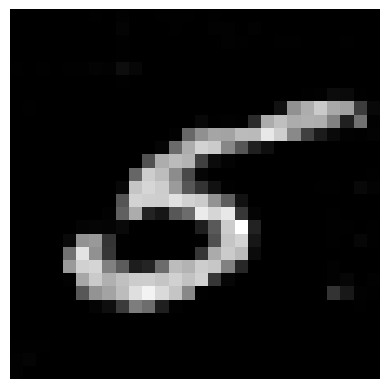

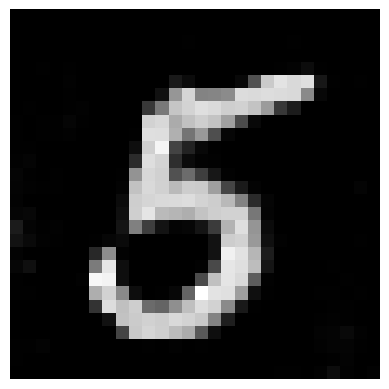

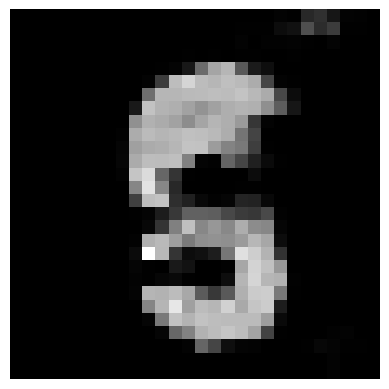

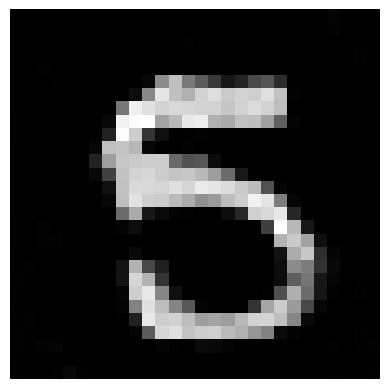

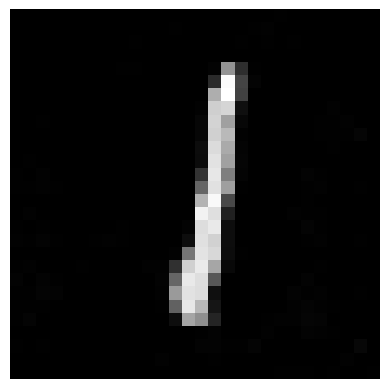

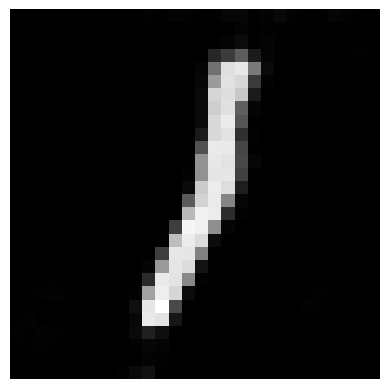

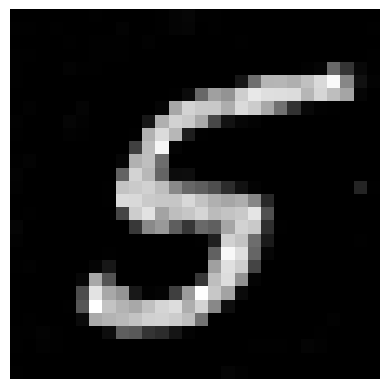

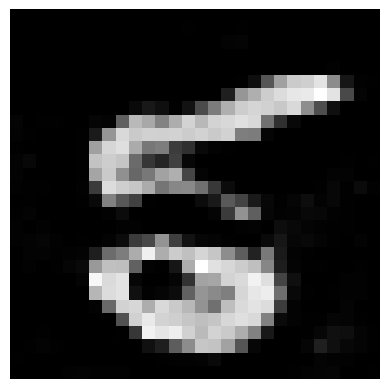

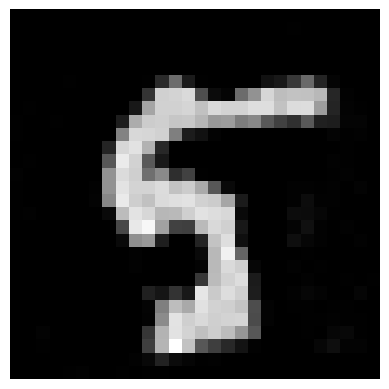

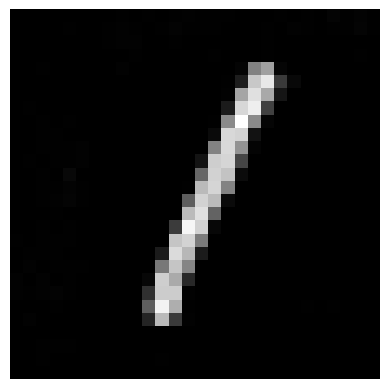

In [23]:
# Generating and inspecting images produced by a GAN's generator.
def generate_images(generator, codings_size, num_images, save_dir='generated_images'):
    # Generate random noise
    random_noise = tf.random.normal(shape=[num_images, codings_size])

    # Use the generator to create images from the noise
    generated_images = generator.predict(random_noise)

    # Rescale if using tanh activation in the last layer
    generated_images = (generated_images + 1) / 2

    # Create directory to save images if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save each image
    for i, image in enumerate(generated_images):
        # Adjust depending on image format
        plt.imshow(image[:, :, 0], cmap="gray")  # Adjust depending on image format
        plt.axis("off")
        plt.show()
# Example images generated from generator
generate_images(gan.layers[0], codings_size, 10, 'path_to_save_images')

## Summary

The Importance of GANs in Digit Recognition Models
- Data Augmentation:

GANs are capable of generating realistic images of digits, such as 1 and 5, offering a solution for augmenting datasets where original samples might be limited.

- Advanced Feature Learning:

The process of generating digits enables GANs to learn robust and intricate features of these numbers, potentially enhancing the performance of digit recognition models.

- Efficacy with Unlabeled Data:

GANs excel in unsupervised learning contexts, proving advantageous in scenarios with a surplus of unlabeled digit images.

- Discriminator as a Recognition Tool:

The discriminator component of a GAN, trained to distinguish between real and generated images, can evolve into an effective mechanism for accurate digit recognition.

Incorporating GANs into digit recognition endeavors can provide significant benefits, including the enrichment of training data and the acquisition of deep, representative features of specific digits like 1 and 5.like 1 and 5.